In [1]:
# Uncomment to upgrade packages
#!pip3 install pandas --upgrade --quiet
#!pip3 install numpy --upgrade --quiet
#!pip3 install scipy --upgrade --quiet
#!pip3 install statsmodels --upgrade --quiet
#!pip3 install seaborn --upgrade --quiet
#!pip3 install matplotlib --upgrade --quiet
#!pip3 install scikit-learn --upgrade 
!pip install scikit-optimize --quiet
!pip install apafib --upgrade --quiet

Objetivos de aprendizaje:
1. Conocer las arquitecturas de perceptrón multicapa y redes convolucionales
2. Conocer las funciones de error según el tipo de tarea de un problema
3. Experimentar con diferentes configuraciones para una red y saberlas ajustar para
diferentes tipos de problemas

# Problema 1

Determianr si el agua es potable o no, es un problema importante. Pero se puede comprobar a partit de un conjunto de características del agua. Nuestro conjunto de datos contiene análisis de muestras de agua que usaremos para decidir si es potable o no.

Los datos se pueden obtener de la libreria `apafib` mediante `load_potability`. 

In [ ]:
import pandas as pd

import scipy.stats as stats

import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  StandardScaler
from sklearn import set_config

from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TunedThresholdClassifierCV,GridSearchCV,train_test_split, cross_val_score


from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.target.feature_correlation import feature_correlation
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, accuracy_score, f1_score, precision_score, recall_score

import warnings
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [3]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

## Apartat a)
 - Eliminar els exemples amb valors perduts (difícils d'imputar)
 - Dividir el conjunt de dades en (80%/20%)
 - Exploració del conjunt d'entrenament observant les relacions amb la variable objectiu
 - Estandaritzar les variables
 - Aplicar PCA i fer visualització en 2D
 - Observar la distribució de la variància en els components
 - Hi ha relació entre les variables i la variable objectiu? Podria ser no lineal?

In [4]:
from apafib import load_potability
# Carreguem dataset
potability = load_potability()
potability.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890,20791.319,7.300,368.516,564.309,10.380,86.991,2.963,0
1,3.716,129.423,18630.058,6.635,NaN,592.885,15.180,56.329,4.501,0
2,8.099,224.236,19909.542,9.276,NaN,418.606,16.869,66.420,3.056,0
3,8.317,214.373,22018.417,8.059,356.886,363.267,18.437,100.342,4.629,0
4,9.092,181.102,17978.986,6.547,310.136,398.411,11.558,31.998,4.075,0


### Eliminar valors perduts

In [5]:
potability_NoNull = potability.dropna()
print('Files Originals:', len(potability), 'Files després de treure valors perduts', len(potability_NoNull))
print('''En total s'han eliminat''', len(potability)-len(potability_NoNull), 'files amb valors perduts')

Files Originals: 3276 Files després de treure valors perduts 2011
En total s'han eliminat 1265 files amb valors perduts


Veiem que n'hi ha un munt de valors perduts, com l'enunciat demana que els eliminem, doncs així fem. Però cal destacar que hem eliminat més d'un 1/3 del conjunt de dades, el que potser afecta a la capacitat de generalització del nostre model.

### Dividir el conjunt

In [6]:
X = potability_NoNull.drop(columns=['Potability'])
y = potability_NoNull['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73, stratify=y)
print(X_train.shape)
print(X_test.shape)

(1608, 9)
(403, 9)


### Exploració del conjunt d'entrenament observant les relacions amb la variable objectiu

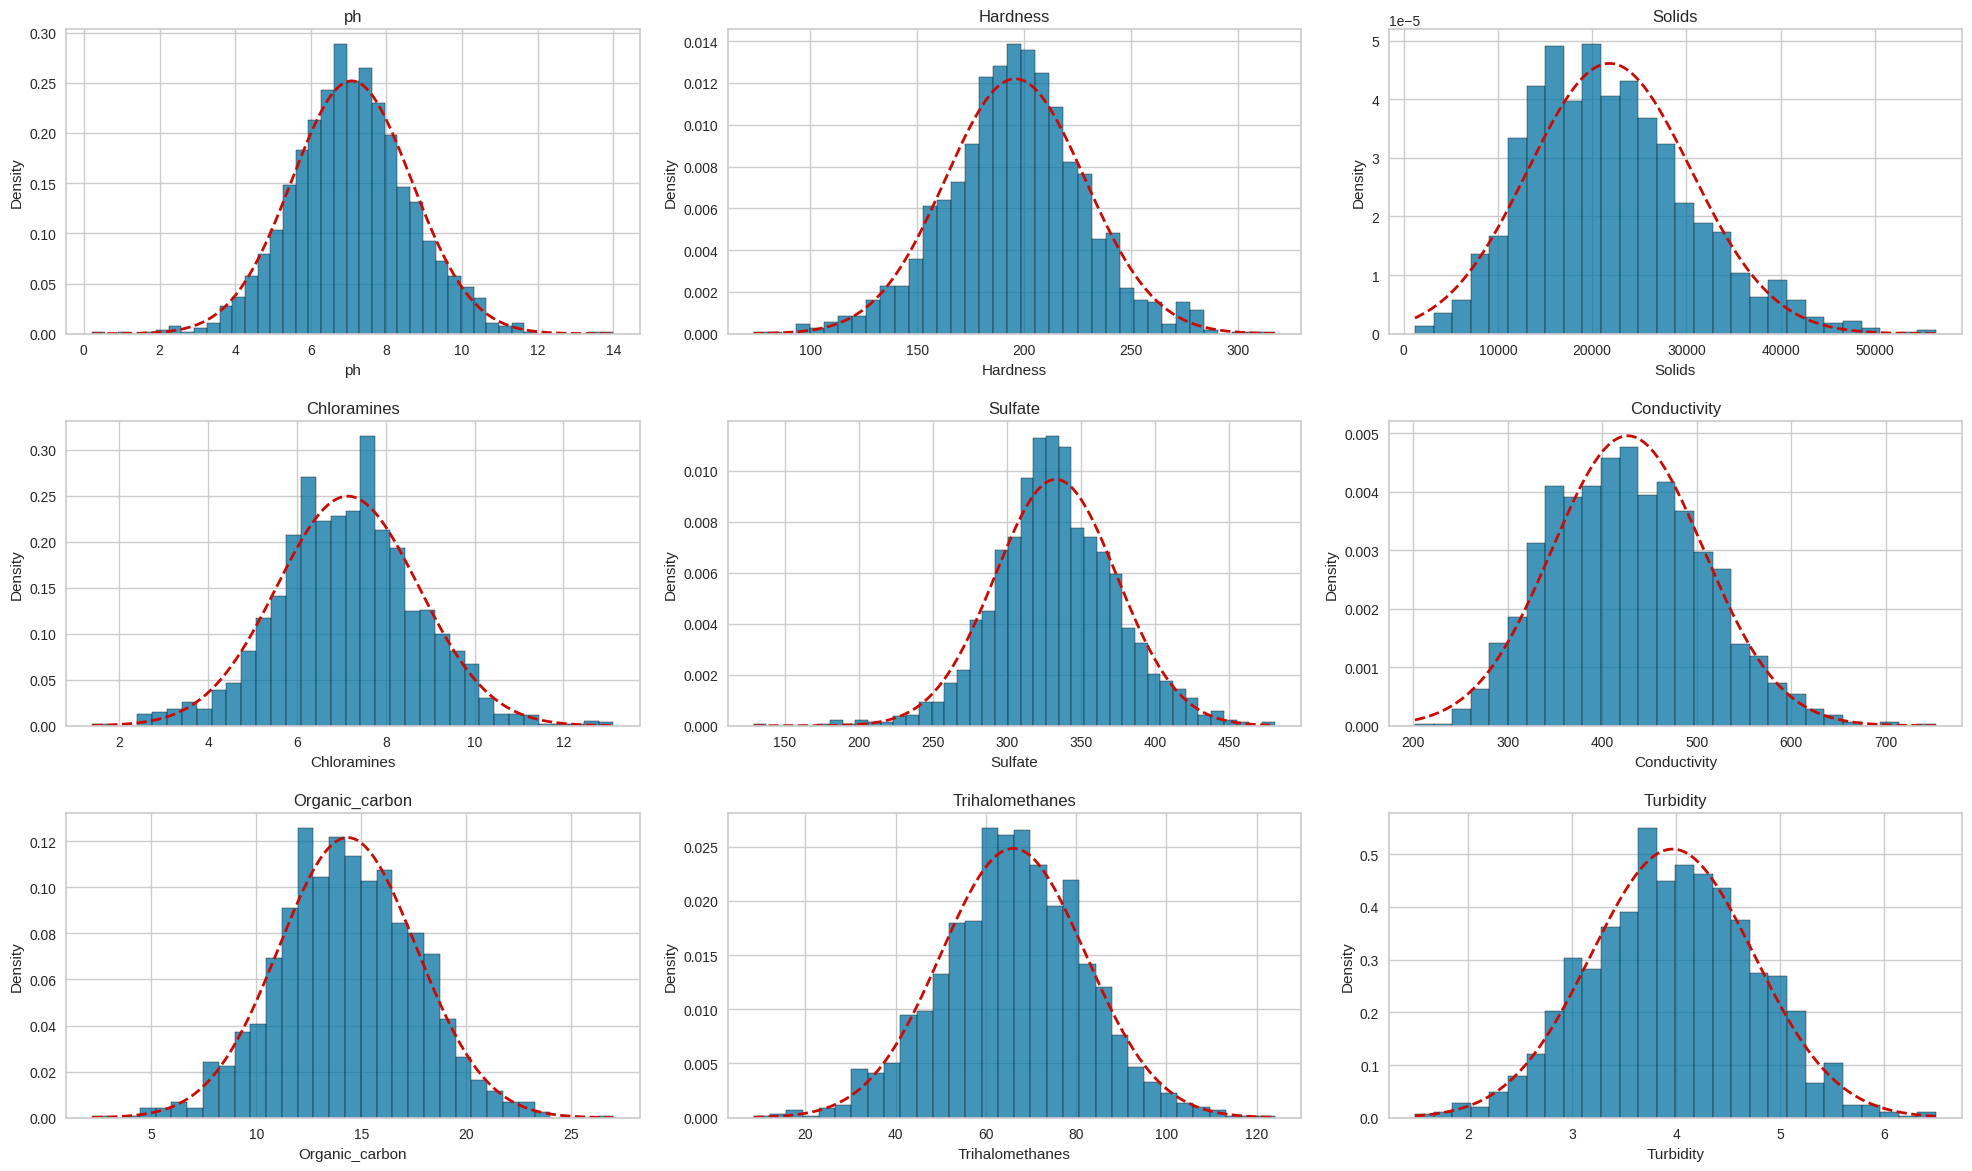

In [7]:
fig, axes = plt.subplots(3,3,figsize=(20,12))
X_train_frame = pd.DataFrame(X_train)
X_train_frame.columns = X_train.columns
for i, c in enumerate(X_train.columns):
    ax = axes.reshape(-1)[i]
    data = X_train[c].dropna()
    sns.histplot(data, ax=ax, stat='density', color='C0', edgecolor='k')
    mu, std = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 200)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r--', lw=2)
    ax.set_title(c)
    ax.legend()
plt.tight_layout()
plt.show()

En general totes les variables segueixen una distribució aproximadament normal, ara el que ens hauríem de preguntar és de com es relacionen amb la variable objectiu `potability`. Per veure aquesta relació, doncs necessitarem veure si les distribucions de cada variable entre aigua potable i no potable són diferents, és a dir, si es mostra alguna tendència clara. Per veure això, es podria fer amb un boxplot o violinplot per poder veure les distribucions segons la variable objectiu. Opto per fer un violinplot ja que crec que és més visual per aquest cas.



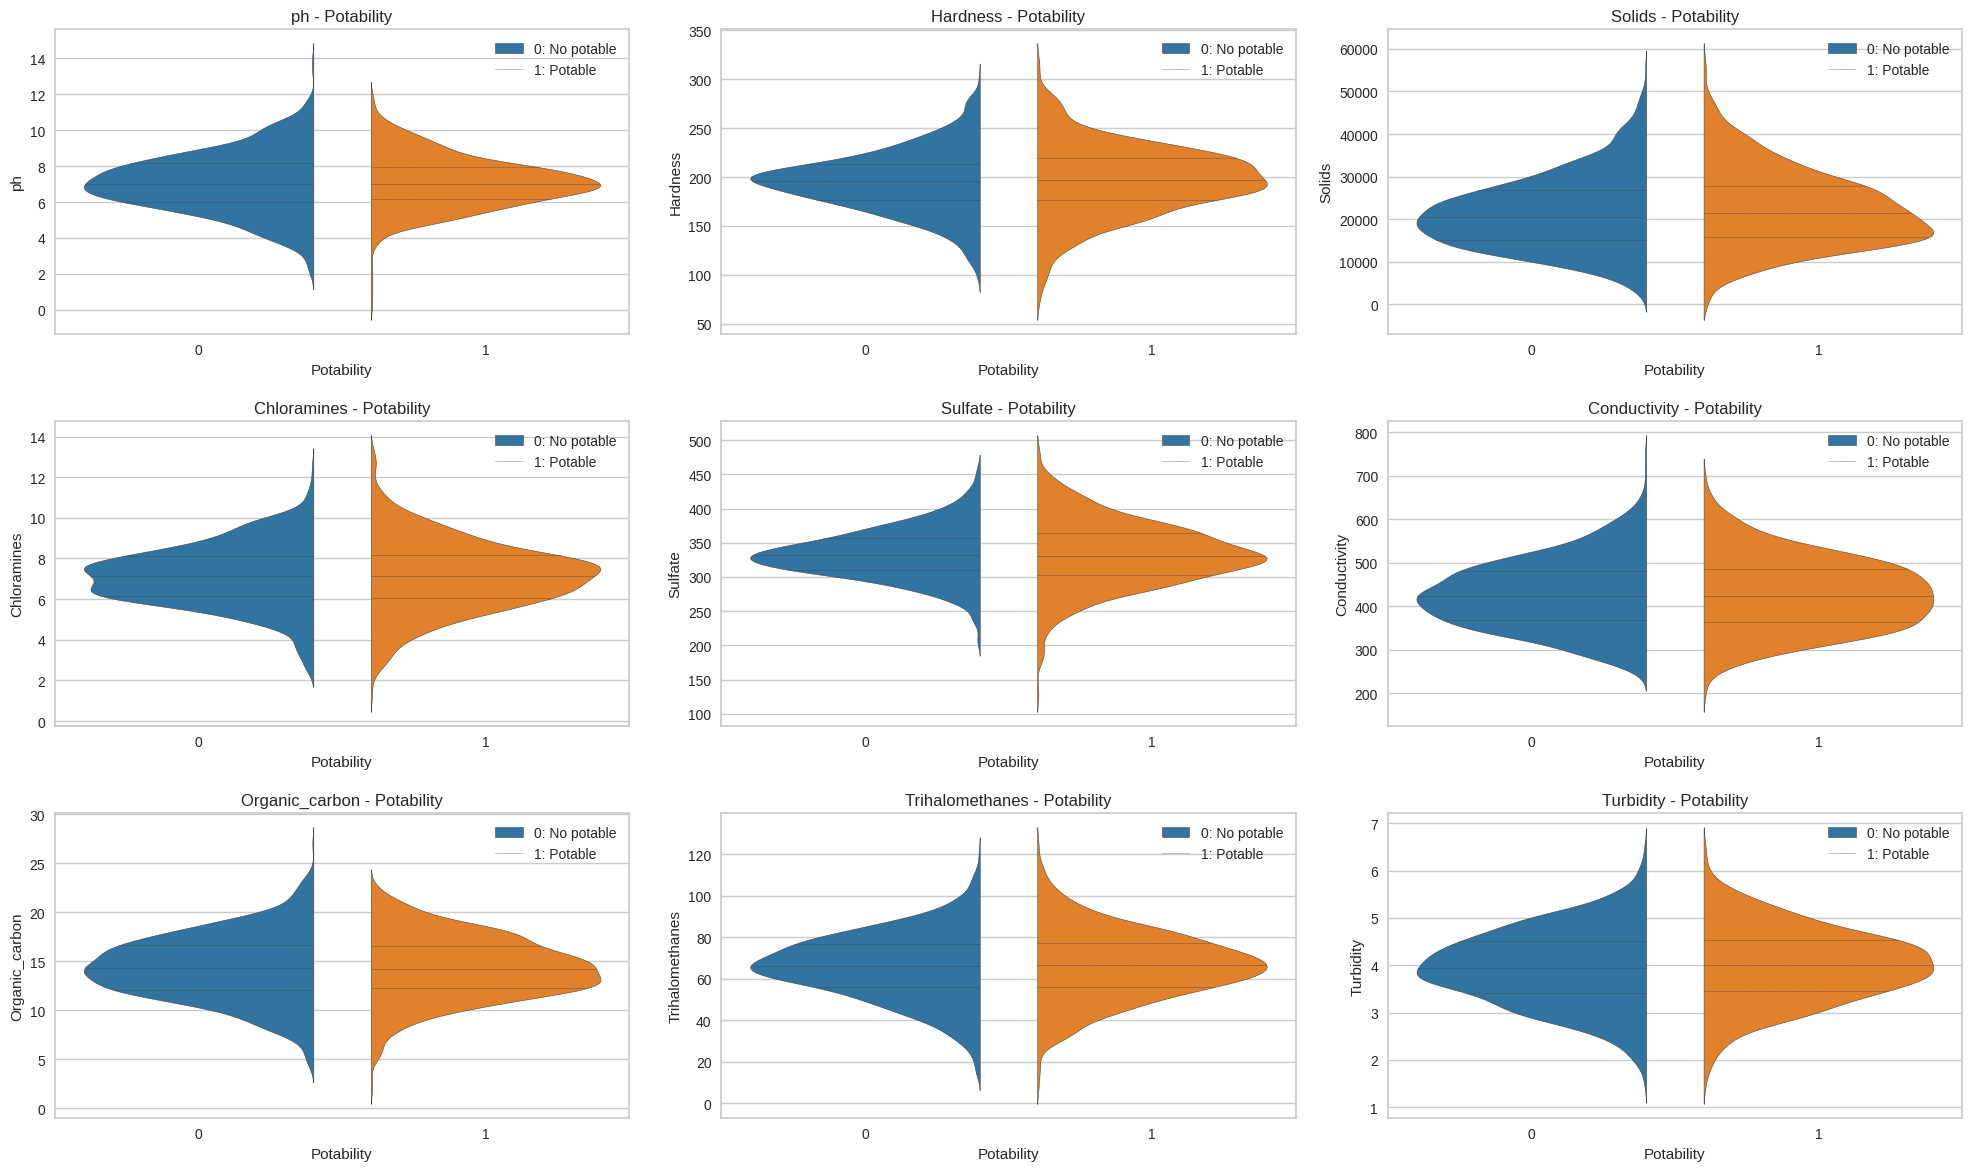

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))

for i, col in enumerate(X_train.columns):
    ax = axes.reshape(-1)[i]
    sns.violinplot(x=y_train, y=X_train[col], palette='tab10', split=True, inner='quartile', ax=ax)
    ax.set_xlabel('Potability')
    ax.set_ylabel(col)
    ax.set_title(f'{col} - Potability')
    ax.legend(['0: No potable', '1: Potable'])
plt.tight_layout()
plt.show()

Podem veure el que ja pansavem, les variables no es distribueixin especialment diferents depenent del grup de potability. Que vull dir? Doncs que la distribució dels dos grup (potable i no potable) és pràcticament igual pels dos casos. A jutjar per això, doncs probablement el nostre model te poc poder predictiu en l'hora de dictaminar la `Potability`, ja que totes les variables es distribueixen igual o bé de forma molt similar entre les dues classes.

Podríem començar a sospitar que potser no hi ha gaire relació lineal entre les variables i la potabilitat.

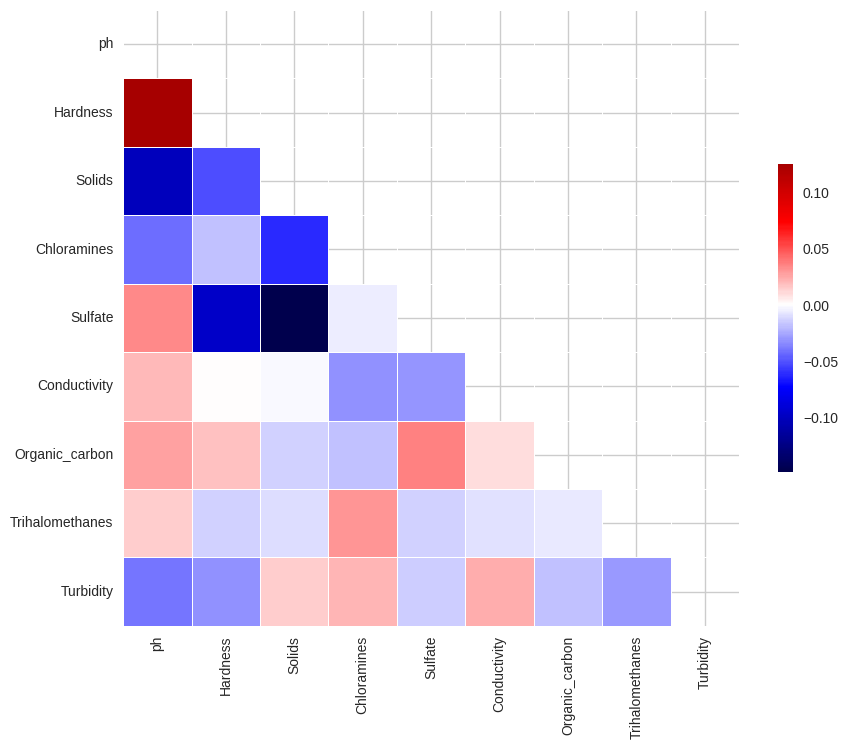

In [9]:
corr = X_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Pel que fa la matriu de correlacions, sí que hi ha un parell que tenen una correlació "relativament forta" com ara **Hardness**-**ph** i en negatiu tindriem **Sulfate**-**Solids**. Les correlacions entre variables són molt baixes (±0.15), per tant les relacions lineals entre predictors són febles i cap variable sola sembla aportar molt senyal per predir `Potability`.

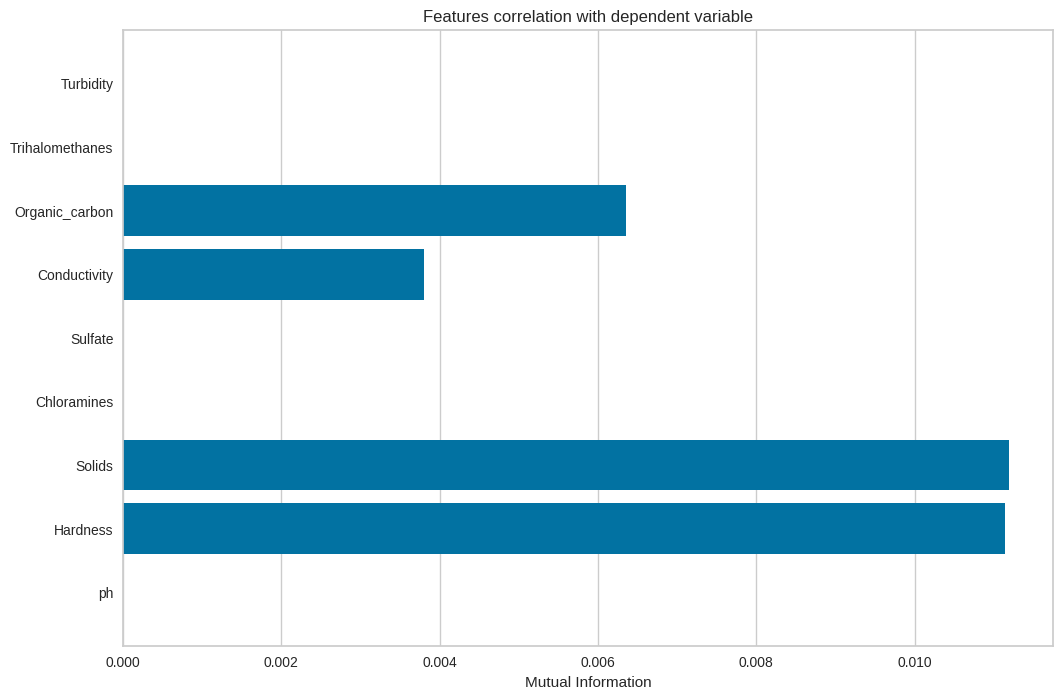

<Figure size 800x550 with 0 Axes>

In [10]:
plt.figure(figsize=(12,8));
visualizer = feature_correlation(X_train, y_train, labels=list(X_train.columns), method='mutual_info-classification', random_state=92);
plt.tight_layout();
plt.show();

Aquí podem veure que les variables amb més relació amb l'objectiu són **Hardness** i **Solids**, amb un valor de ~0.012, però en general veiem el mateix que abans. Cap variable per si sola aporta un senyal fort evident, ja que la relació amb l'objectiu és dèbil. 

A jutjar per les dades i totes les visualitzacions fetes, ens pot fer pensar que el model amb bastanta probabilitat és no lineal.

### Estandaritzar les variables

In [11]:
scaler = StandardScaler()
X_train_sd = scaler.fit_transform(X_train)
X_test_sd = scaler.transform(X_test)

### PCA i fer visualització

In [12]:
pca = PCA().fit(X_train_sd);

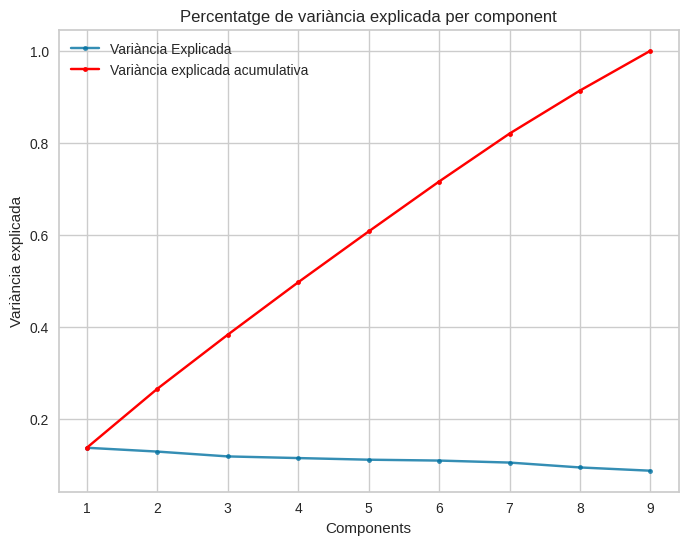

In [13]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variància Explicada");
y_label = plt.ylabel('Variància explicada');
x_label = plt.xlabel('Components');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variància explicada acumulativa");
plt.legend();
plt.title('Percentatge de variància explicada per component');

Què podem veure? Doncs que cada component aporta més o menys la mateixa quantitat de variància. Si que és cert que el primer component aporta una mica més (~14%), però no és un canvi molt gran respecte la resta (l'últim aporta ~8%). També ho jutgem per la variància acumulada, que creix de forma bastant lineal i uniforme. Per arribar al 80% de la variància acumulada, necessitem uns 7 components, i si agafem només 2, només expliquem un ~30% de la variància total. El que ens fa pensar que el PCA serà poc clar.

Que ens fa pensar? Doncs que no hi ha cap combinació lineal de les variables que expliqui gairebé tota la variància, com hem dit abans, no sembla que hi hagi una relació lineal forta entre les variables i l'objectiu.

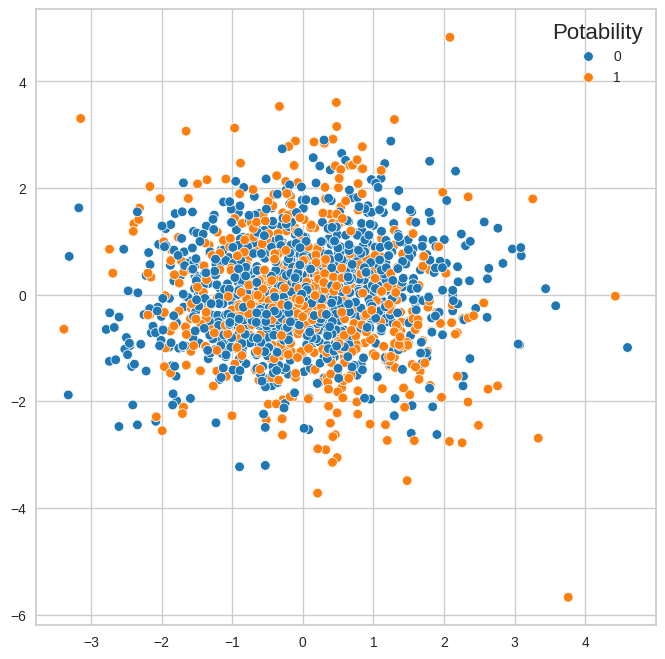

In [14]:
X_train_pca = pca.transform(X_train_sd)
X_test_pca = pca.transform(X_test_sd)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train, palette='tab10');

Res més a afegir, el que ja hem vist amb la variància acumulada: en dos components no som capaços de separar gairebé res. Els dos grups clarament es barregen i no es pot observar cap patró clar entre ells.

### Hi ha relació entre les variables i la variable objectiu? Podria ser no lineal?
He anat comentat al llarg de tot l'apartat, però anem a fer una resposta clara i directa.

És lineal? Les resposta clara és que no ho sembla, no sembla que hi hagi una relació lineal forta entre les variables ni amb l'objectiu. Ja que les correlacions són molt baixes i les distribucions de les variables segons la potabilitat són molt similars, i a més en el PCA les classes estan completament superposades.

Podria ser no lineal? Doncs podria haver dues respostes possibles:
1. Sí, és no lineal, les interaccions entre múltiples variables podrien determianr la probabiliat (encara no ho sabem).
2. No hi ha relació, ni lineal ni no lineal, potser les variables simplement no contenen prou informació per determinar la potabilitat.

Però si m'haig de decantar per una, seria per sí que és **no lineal**, però ara ho veurem.

## Apartat b)
 - Ajusta un Naïve Bayes
 - Ajusta una regressió logística
 - Avaluar els models

### Naïve Bayes


In [15]:
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train_sd,y_train,cv=10))
print(gnb.best_score_)

0.6156560559006211


Jutjant per la validació creuada no sembla que el Naïve Bayes funcioni gaire bé, ja que només aconsegueix un ~62% de precisió.

In [16]:
gnb_model = GaussianNB().fit(X_train_sd, y_train)
gnb_model.best_score_ = gnb.best_score_

print("Priors:", gnb_model.class_prior_)

Priors: [0.59701493 0.40298507]


In [17]:
y_pred_gnb_test = gnb_model.predict(X_test_sd)
results_df = save_results(gnb_model, X_test_sd, y_test, 'GNB', results_df)
print(classification_report(y_test, y_pred_gnb_test))

              precision    recall  f1-score   support

           0       0.63      0.88      0.74       240
           1       0.59      0.25      0.35       163

    accuracy                           0.63       403
   macro avg       0.61      0.56      0.54       403
weighted avg       0.61      0.63      0.58       403



Els resultats son bastant desastrosos, hi ha un **accuracy del 63%**, precissió del 61%, recall del 50% i f1-score del 54%. Pel que fa a nivell individual; la classe 0 encara és podria salvar una mica, ja que té un f1-score acceptable el 74%, el recall és alt (88%) però la precissió es baixa (63%) el que ens dius que hi ha molts falsos positius; però es que la seva companya té un f1-score de només 35%, és molt molt baix, un recall encara pitjor (25%), cosa que ens dius que no detecta bé la classe 1. En general no es un bon model per les nostres dades.

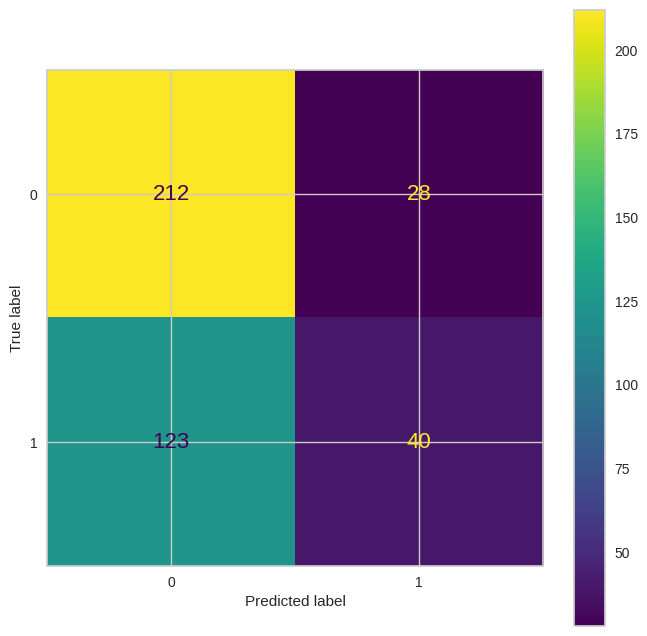

In [18]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_sd, y_test, ax=plt.subplot());

Res nou que no haguem comentat al classification report, la classe 0 (no potable) és la que millor detecta, però és que la classe 1 la classifica fatal, el model prediu 123 com a no potable quan en realitat són potables.
És a dir, el nostre model li costa predir aigua potable.
A més, afegir que el model en la classe 0, te 28 falsos positius, el que és relativament bastant alt ja que estem parlant de termes mèdics.

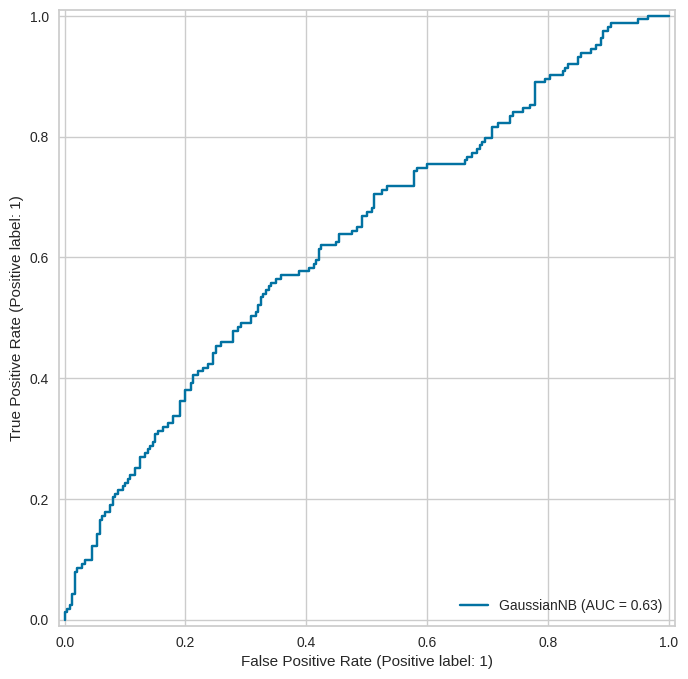

In [19]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(gnb_model, X_test_sd, y_test, ax=plt.subplot());

Amb tot el respecte, la corba ROC és horrible, no s'allunya gaire de ser una línia recta. Que vol dir? Doncs que aquest model té molt poca capacitat discriminativa, no és gaire millor que un model aleatori.

Faig un matís ara que servirà d'ara endavant: la corba ROC serveix per mesurar la **capacitat discriminativa** del model (el seu potencial), però no serveix per dictaminar si un model és **útil o segur** perquè aixó depen del problema. És a dir, dos models poden tenir el mateix valor d'AUC però comportar-se de manera molt diferent a la pràctica (per exemple, tenint molts més falsos positius un que l'altre), i això ho veurem més endavant.

### Regressió Logística

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,51, endpoint=True)}
lr_gs = GridSearchCV(lr, param, cv=10, n_jobs=-1, refit = True)
lr_gs.fit(X_train_sd, y_train);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

lr_prediction = lr_gs.predict(X_test_sd)
results_df = save_results(lr_gs, X_test_sd, y_test, 'Logistic Regression', results_df)

,params,mean_test_score,rank_test_score
49,"{'C': 0.7585775750291835, 'penalty': 'l2'}",0.599,1
51,"{'C': 1.0, 'penalty': 'l2'}",0.599,1
55,"{'C': 1.7378008287493745, 'penalty': 'l2'}",0.599,1
53,"{'C': 1.3182567385564075, 'penalty': 'l2'}",0.599,1
61,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.599,1


Tots aquests 5 hiperparàmetres han obtingut el mateix valor en la mean_test_score, però ens quedarem amb el primer:
 - **Penalty**: l2
 - **C**: 0.7585775750291835
 - **Accuracy**: 59.9%

In [21]:
print(classification_report(y_test, lr_prediction))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       240
           1       0.50      0.01      0.01       163

    accuracy                           0.60       403
   macro avg       0.55      0.50      0.38       403
weighted avg       0.56      0.60      0.45       403



En aquest cas, comparant amb Naïve Bayes, te un **accuracy** menor (60% vs 63%). Pel que fa la resta de metriques globals son totes pitjors, cal destacar el pobre **f1-score** de 38%. A nivell individual la classe 1, practicament no la detecta, té un recall del 1%, el que fa que tingui un f1-score de només 1%. La classe 0 té millor f1-score, de 75%, té un recall molt alt del 100% el que singifica que n'hi ha molts falsos positius. En general aquest model sembla pitjor que el Naïve Bayes.

En general aquest model és pitjor que el Naïve Bayes.

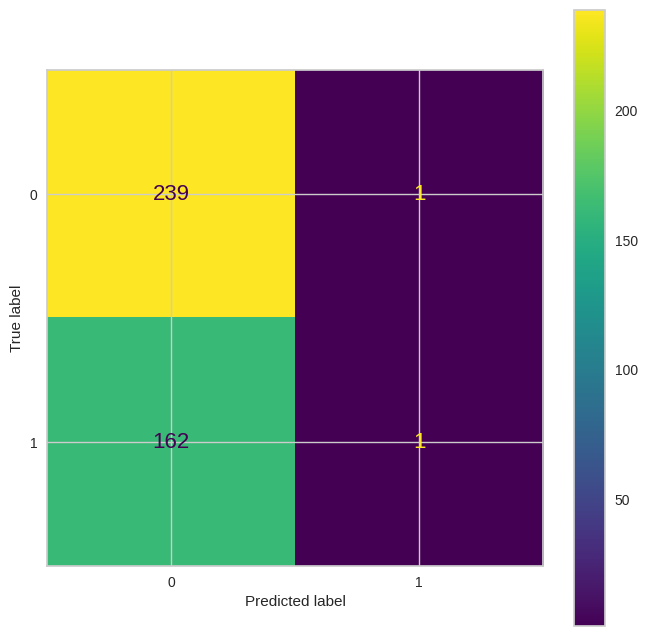

In [22]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_sd, y_test, ax=plt.subplot());

No hauriem d'estar orgullosos d'aquest model, gràcies a la matriu de confusió podem veure clarament que ho prediu tot com a no potable (classe 0), i només un exemple com a potable (classe 1). Això explica el perquè té un recall del 100% en la classe 0 i del 1% en la classe 1.

És un model molt desequilibrat que en el nostre cas no serveix absolutament per res.


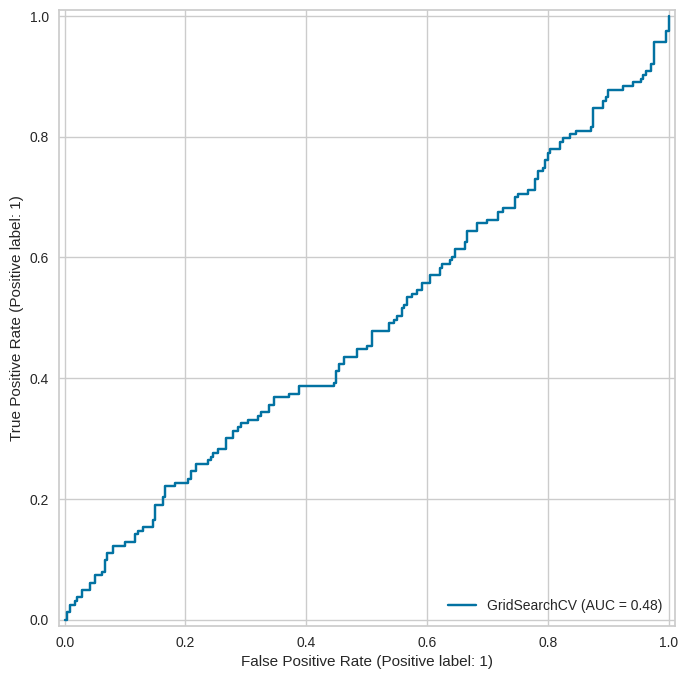

In [23]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(lr_gs, X_test_sd, y_test, ax=plt.subplot());

No n'hi ha qui vulgui aquest model, té un **AUC de només 0.48**, que es pitjor que un model aleatori (0.5). El que vol dir que literalment prediu pitjor que llançar una moneda. La corba ROC està fins i tot per sota la diagonal, que ens fa pensar que aquest model no ha aprés res útil.

### Avaluar els models

In [24]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
GNB,0.616,0.625,0.611,0.564,0.542
Logistic Regression,0.599,0.596,0.548,0.501,0.379


D'aquests dos models, el **Naïve Bayes** és clarament millor que la **Regressió Logística**, ja que literalment totes les mètriques són superiors. Però és que els resultats són decepcionants.  

Però és que deixant de banda aquest problema, els resultats no són gens bons, estem parlant d'un problema mèdic i no podem acceptar accuracys al voltant del 60%. A més, els dos models tenen un recall baix (al voltant del 50%), que vol dir? Doncs que classificarà malament la qualitat de l'aigua. 

Ja centrant-me en un model en específic, el de **Regressió Logística** és que no fa res, prediu tot com a no potable.

Per què podrien fallar? Com hem vist a l'apartat a), les variables no mostren relació lineal amb l'objectiu, totes les variables es distribueixen de forma molt similar i en el PCA no es veia res. Què vull dir amb això? Doncs que un model lineal no pot predir res amb aquestes dades. 

Que podem conclure? Donc que clarament **el problema no és lineal**.

## Apartat c)
 - Ajusta un MLP amb una capa oculta i explora el hiperparàmetres
 - Compara resultats amb models anteriors

### MLP

In [25]:
param = {'hidden_layer_sizes':[10, 25, 50, 75, 100, 200], 
         'activation':['relu', 'logistic', 'identity'], 
         'learning_rate_init': [0.001, 0.005, 0.01, 0.05, 0.1],
         'alpha':[0.0001, 0.001, 0.01],  }

mlp =  MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=20,learning_rate='adaptive',random_state=54)
mlp_gs = GridSearchCV(mlp,param,cv=cv, n_jobs=-1, refit=True)
mlp_gs.fit(X_train_sd, y_train);

show_html(pd.DataFrame(mlp_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
18,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 75, 'learning_rate_init': 0.05}",0.683,1
73,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.05}",0.682,2
133,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.05}",0.682,3
74,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.1}",0.681,4
48,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 75, 'learning_rate_init': 0.05}",0.681,5


Jutjant pels valors anteriors, ara tenim millro valor de validació creuada (68.3%). Millor hiperparàmetre:
 - **activation**: relu
 - **alpha**: 0.0001
 - **hidden_layer_size**: 75
 - **learning_rate_init**: 0.05

In [26]:
y_pred_mlp = mlp_gs.predict(X_test_sd)

print(classification_report(y_test, y_pred_mlp))
results_df = save_results(mlp_gs, X_test_sd, y_test, 'MLP', results_df)

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       240
           1       0.61      0.61      0.61       163

    accuracy                           0.69       403
   macro avg       0.68      0.67      0.67       403
weighted avg       0.69      0.69      0.69       403



Els resultats son bastant similars els que ja teniem, si que es cert que ara tenim una mica més d'**acuraccy** 69%. Cal destacar que a nivell individual, el **recall** de la classe 1 ha millorat, però té una precissió relativament baixa de 61%. 
Aquestes millores ens fan pensar que el model ha captat les relacions no lineals. Ara amb la matrius de confussió ho podrem veure.

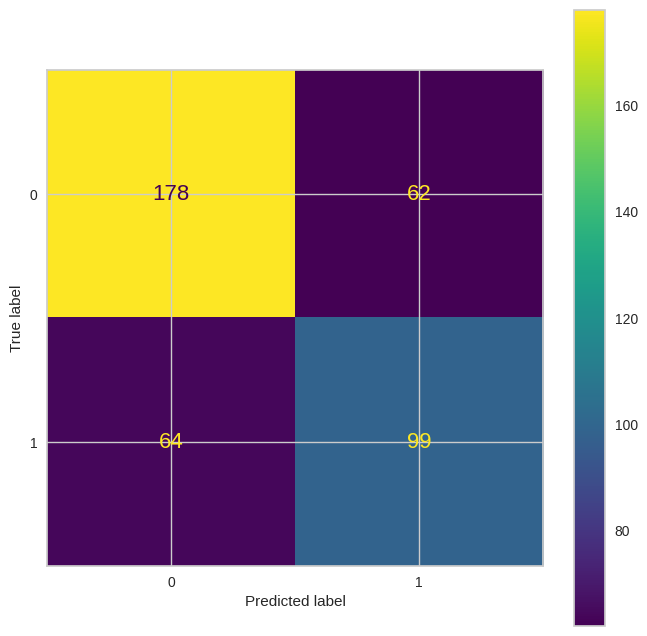

In [27]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp_gs, X_test_sd,y_test, ax=plt.subplot());

Que es pot veure? Doncs que la classe 0 segueix sent la més ben detectada, i també (com hem dit al classification report), la classe 1 es detecta millor que en els altres models. Comparant amb els altres models és el que detecte més cassos de la classe 1.
Però no tot son roses, estem parlant d'un problema de salut, i que aquest model és qui ha coment més falsos positius en detectar aigua potable quan no ho era. 

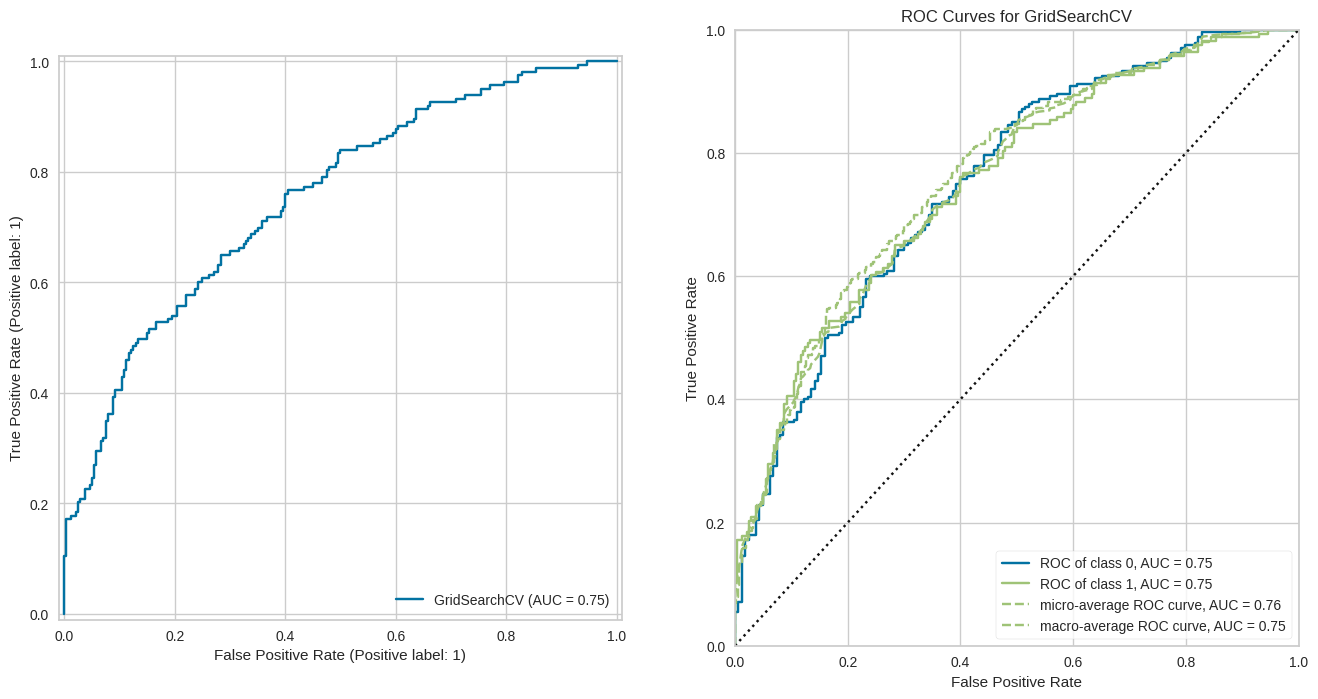

<Figure size 800x550 with 0 Axes>

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
RocCurveDisplay.from_estimator(mlp_gs, X_test_sd, y_test, ax=axes[0])
roc_auc(mlp_gs, X_train_sd, y_train, X_test_sd, y_test, ax=axes[1])
plt.tight_layout()
plt.show()

Cal dir que de totes les curves ROC que hem vist és la millor, amb un **AUC** de 0.75. Podem veure que les dos classes, la 0 i la 1 es prediuen practicament igual, cosa que abans no passava.

### Comparar resultats amb models anteriors

In [29]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
MLP,0.683,0.687,0.675,0.675,0.675
GNB,0.616,0.625,0.611,0.564,0.542
Logistic Regression,0.599,0.596,0.548,0.501,0.379


El millor model és **MLP**, que supera a totes les mètriques dels altres models, i també és el que té millor valor en la corba ROC (0.75 vs el 0.63 del **GNB** i el 0.48 del **LR**). Té un **accuracy** de quasi el 69% i un **f1-score** del ~68% que és ~13% millor que el **GNB** el que ens fa pensar que ha aprés a distingir entre aigua potable i no potable. També vull dir que tots els models s'ajusten bé, ja que els resultats de train i test són molt semblants

Amb aquests resultats que ens pot fer pensar, per què és millor el **MLP**? Doncs que al afegir una capa oculta ha permés contemplar relacions no lineals entre les variables, cosa que ha afavorit al nostre model. Gràcies aquest aparatat, podem afirmar que té relacions **no lineals**.

Però vull destacar un altre vegada, que és un problema de salut, i el **MLP** classifica moltes aigue com a potables quan no ho són.

## Apartat d)
 - Utilitzar el model TunedThresholdClassifierCV (optimitzar per accuracy i roc_auc)
 - Utilitzar el modelo CalibratedClassifierCV
 - Ajustar el llindar de probabilitat per al classificador calibrat
 - Compara els resultats

### TunedThresholdClassifierCV 

In [30]:
# Optimitzant amb accuracy
tuned_acc = TunedThresholdClassifierCV(
    estimator=mlp_gs,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
tuned_acc.fit(X_train_sd, y_train)

print(f"Llindar òptim (accuracy): {tuned_acc.best_threshold_:.3f}")

Llindar òptim (accuracy): 0.494


In [31]:
y_pred_tuned_acc = tuned_acc.predict(X_test_sd)
results_df = save_results(tuned_acc, X_test_sd, y_test, 'MLP + TunedThreshold (acc)', results_df)
print(classification_report(y_test, y_pred_tuned_acc))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       240
           1       0.61      0.61      0.61       163

    accuracy                           0.68       403
   macro avg       0.67      0.67      0.67       403
weighted avg       0.69      0.68      0.69       403



Podem veure valors **gairebé idèntics** que en el **MLP** inicial. Ens trobem amb un **accuracy** de 68% igual que el del MLP original. Això és esperat perquè el llindar òptim per `accuracy` està molt prop del 0.5 per defecte, per tant els canvis són mínims. Mirarem amb la matriu de confusió i la corba ROC si n'hi ha algun canvi significatiu.

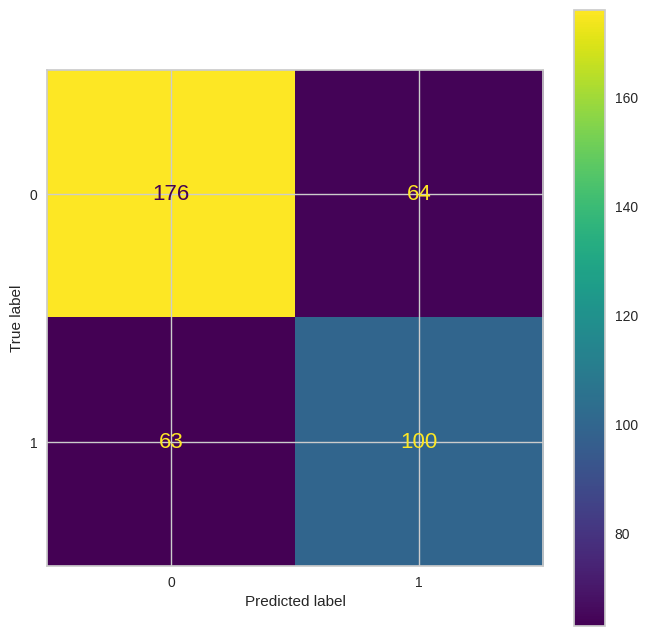

In [32]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(tuned_acc, X_test_sd,y_test, ax=plt.subplot());

Bé, mateixes conclusions que abans, no és veu un canvi significatiu amb el **MLP** sense tunejar. Només les classificacions varien 1-2 amunt i avall respecte aquest. Així que no es veu una millora considrebale.

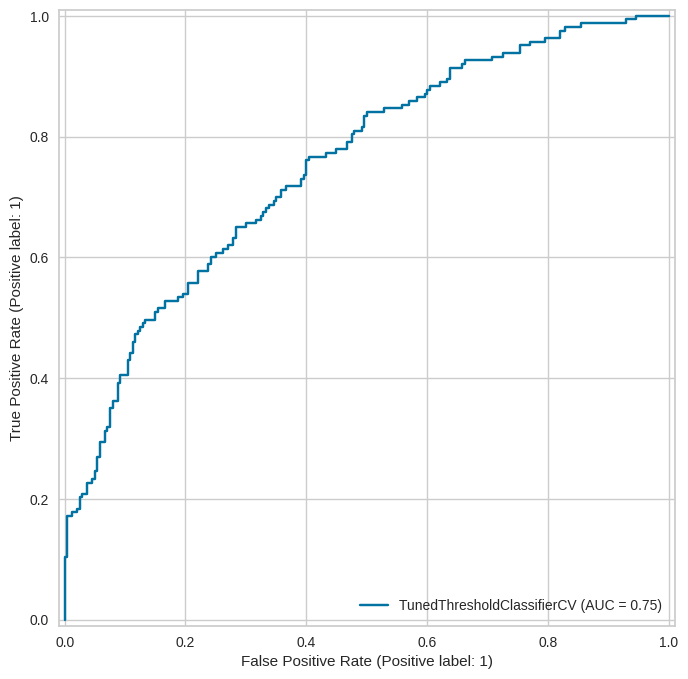

In [33]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(tuned_acc, X_test_sd, y_test, ax=plt.subplot());

I com ja anavem dient, corba ROC molt similar al **MLP** inicial. Té el mateix valor d'**AUC** de 0.75. Tunejar per accuracy no és útil en aquest context perquè no millora significativament els resultats. Anem a veure si optimitzant amb *roc_auc* donen millors resultats per a aquest problema mèdic.

In [34]:
tuned_roc = TunedThresholdClassifierCV(
    estimator=mlp_gs,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
tuned_roc.fit(X_train_sd, y_train)

print(f"Llindar òptim (roc_auc): {tuned_roc.best_threshold_:.3f}")


Llindar òptim (roc_auc): 0.415


In [35]:
y_pred_tuned_roc = tuned_roc.predict(X_test_sd)
results_df = save_results(tuned_roc, X_test_sd, y_test, 'MLP + TunedThreshold (roc)', results_df)
print(classification_report(y_test, y_pred_tuned_roc))

              precision    recall  f1-score   support

           0       0.79      0.58      0.67       240
           1       0.55      0.77      0.64       163

    accuracy                           0.66       403
   macro avg       0.67      0.67      0.65       403
weighted avg       0.69      0.66      0.66       403



Que podem dir? Té un **accuracy** del 66%, una mica menys que optimitzant per `accuracy`. Pel que fa a les mètriques globals, són bastant similars als altres models de **MLP**. Destacar que la **precissió** de la classe 1 ha baixat i el **f1-score** de la classe 0 també és el menor dels altres models de **MLP**.

A nivell individual, el **MLP + TunedThreshold (roc_auc)** és el pitjor model dels MLP en termes de f1-score.

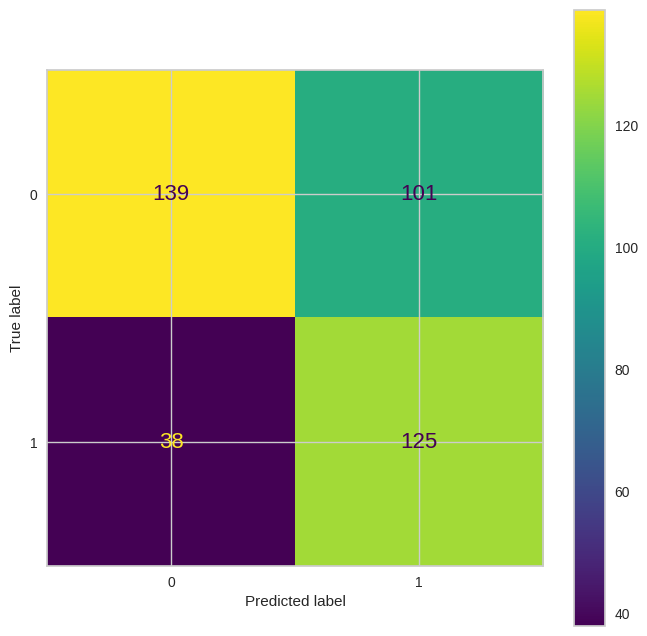

In [36]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(tuned_roc, X_test_sd,y_test, ax=plt.subplot());

Doncs exactament el que deiem, si que prediu molt més la classe 1, però s'equivoca quasi la meitat dels cops (101 falsos positius). Declararia com a potable quasi la meitat de l'agua que no ho és. No és un bon model per a aquest problema.

Optimitzar per roc_auc sense tenir en compte tots els falsos positius podria ser un problema. Ja que és el model amb més falsos positius.

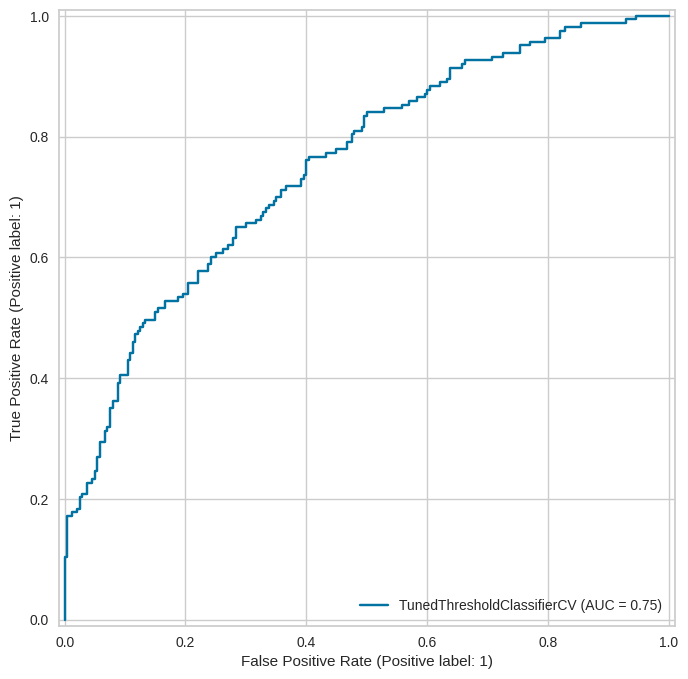

In [37]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(tuned_acc, X_test_sd, y_test, ax=plt.subplot());

Res a dir, te el mateix valors d'**AUC** que dels models que l'hem anat comparant (0.75).

### CalibratedClassifierCV

In [38]:
# Calibrar el model MLP
calibrated = CalibratedClassifierCV(
    estimator=mlp_gs,
    method='isotonic',
    cv=5,
    n_jobs=-1
)
calibrated.fit(X_train_sd, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=GridSearchCV(cv=5,
                                              estimator=MLPClassifier(early_stopping=True,
                                                                      learning_rate='adaptive',
                                                                      max_iter=10000,
                                                                      n_iter_no_change=20,
                                                                      random_state=54),
                                              n_jobs=-1,
                                              param_grid={'activation': ['relu',
                                                                         'logistic',
                                                                         'identity'],
                                                          'alpha': [0.0001,
                                                                    0.001,
       

In [39]:

y_pred_calibrated = calibrated.predict(X_test_sd)
results_df = save_results(calibrated, X_test_sd, y_test, 'MLP + Calibrated', results_df)
print(classification_report(y_test, y_pred_calibrated))


              precision    recall  f1-score   support

           0       0.72      0.85      0.78       240
           1       0.70      0.52      0.59       163

    accuracy                           0.71       403
   macro avg       0.71      0.68      0.69       403
weighted avg       0.71      0.71      0.70       403



Aquí ja veiem millores significatives, té l'**accuracy** més alt que hem vist fins ara, de **71%**.

A nivell individual, la classe 1 (aigua potable) té un **recall** bastant pobre (50%), però la **precisió de 70%** (la més alta vista fins ara). Això redueix drásticament els falsos positius. La classe 0 segueix tenint resultats molt bons amb **recall del 85%** i **f1-score del 78%**, cosa que significa que detecta bé l'aigua no potable.

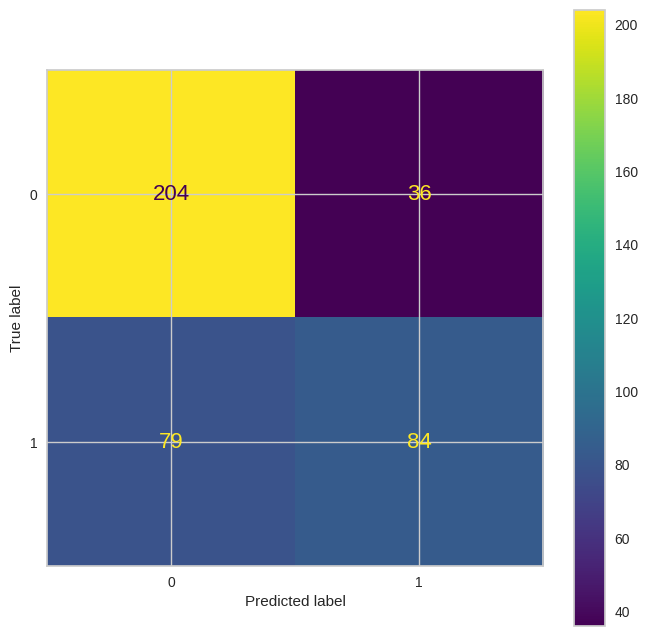

In [40]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(calibrated, X_test_sd,y_test, ax=plt.subplot());

Aquí ja tenim resultats més acceptables, entenem com més acceptables que n'hi ha menys falsos positius de aigua potable. Es pot veure clarament el recall pobre de la classe 1, ja que només contempla la meitat i la altre ho considera com no potable.

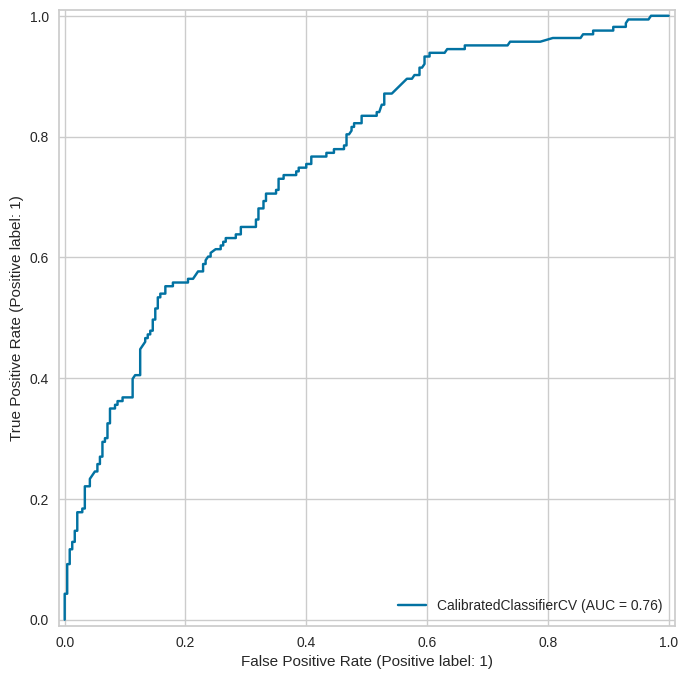

In [41]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(calibrated, X_test_sd, y_test, ax=plt.subplot());

Aquí la cosa ja canvia una miqueta, tenim millor valor de **AUC** que ara val 0.76, de moment és el millor valor que tenim. I el que també significa que de moment el model MLP calibrat amb isotonic és el millor.

Per entrar una mica més en materia, anem a entrenar un model clasificador pasant per paràmetre aquest model calibrat a veure si milloren els resultats, per fer-ho entrenarem un model de TunedThresholdClassifierCV amb `calibrated` com a model i de scoring ho farem optimitzant tant per accuracy i per roc_auc, a veure quin dona millor resultat.

In [42]:
# Ajustar llindar sobre el model calibrat
tuned_calibrated_roc = TunedThresholdClassifierCV(
    estimator=calibrated,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
tuned_calibrated_roc.fit(X_train_sd, y_train)

tuned_calibrated_acc = TunedThresholdClassifierCV(
    estimator=calibrated,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
tuned_calibrated_acc.fit(X_train_sd, y_train)


TunedThresholdClassifierCV(cv=5,
                           estimator=CalibratedClassifierCV(cv=5,
                                                            estimator=GridSearchCV(cv=5,
                                                                                   estimator=MLPClassifier(early_stopping=True,
                                                                                                           learning_rate='adaptive',
                                                                                                           max_iter=10000,
                                                                                                           n_iter_no_change=20,
                                                                                                           random_state=54),
                                                                                   n_jobs=-1,
                                                                                 

In [43]:

y_pred_tuned_cal_roc = tuned_calibrated_roc.predict(X_test_sd)
results_df = save_results(tuned_calibrated_roc, X_test_sd, y_test, 'MLP + Calibrated + Tuned Roc', results_df)
print(classification_report(y_test, y_pred_tuned_cal_roc))

y_pred_tuned_cal_acc = tuned_calibrated_acc.predict(X_test_sd)
results_df = save_results(tuned_calibrated_acc, X_test_sd, y_test, 'MLP + Calibrated + Tuned Acc', results_df)
print(classification_report(y_test, y_pred_tuned_cal_acc))


              precision    recall  f1-score   support

           0       0.77      0.65      0.70       240
           1       0.58      0.71      0.64       163

    accuracy                           0.67       403
   macro avg       0.67      0.68      0.67       403
weighted avg       0.69      0.67      0.68       403

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       240
           1       0.70      0.53      0.60       163

    accuracy                           0.72       403
   macro avg       0.71      0.69      0.69       403
weighted avg       0.71      0.72      0.71       403



Els primers resultats fan referencia a tunejat per **roc_acu** i els segons per **accuracy**.

Pel que fa els de roc_auc:

Té un **accuracy del 67%** (4% menys que el **calibrated** que tenia 71%). A nivell de calsse, la classe 0 té un valor de **f1-score** més baix (70%) respecte el 78% del **calibrated**, en altres paraules, detecta pitjor l'aigua no potable; però en canvi la classe 1 té millor valor, ara val 64%, amb un **recall** del 71% i una **precissió** del 58%, aquest valor tan baix de preccisió es un problema perquè clasifica malament quasi la meitat d'aigua potable.

Pel que fa els d'accuracy:

Tenim un **accuracy del 72%** (1% millor que el calibrated), a valors generals **precision**, **recall** i **f1-score** estan prou bé, estan al voltant del 70%. A nivell intern, comparant amb el **calibrated** no és veu un canvi clar, ja que l'unic que canta a la vista que hem pujat un 1% del f1-score de la classe 1. S'hauria de comportar practicament igual que el **calibrated**.


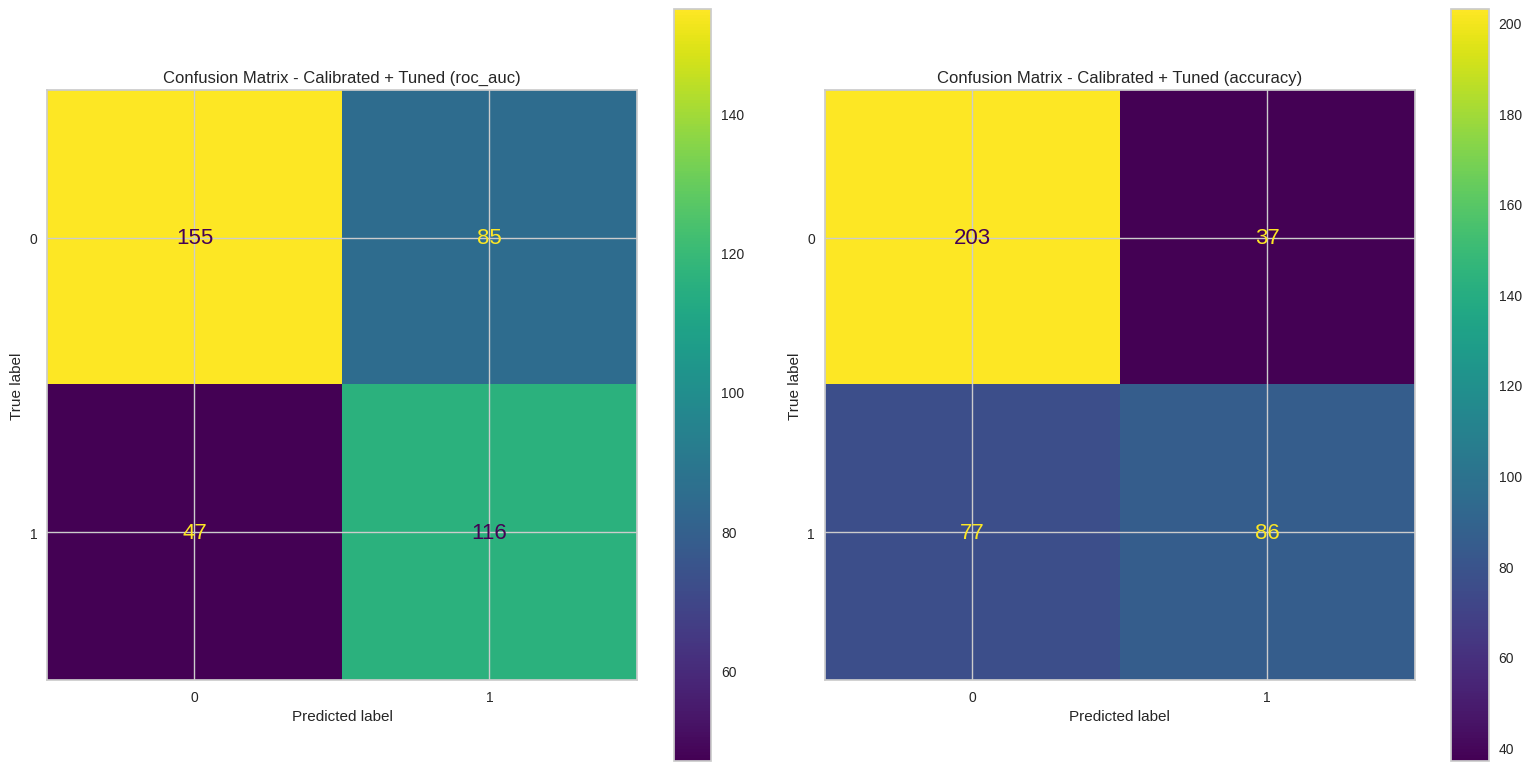

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ConfusionMatrixDisplay.from_estimator(tuned_calibrated_roc, X_test_sd,y_test, ax=axes[0])
ConfusionMatrixDisplay.from_estimator(tuned_calibrated_acc, X_test_sd, y_test, ax=axes[1])
axes[0].set_title('Confusion Matrix - Calibrated + Tuned (roc_auc)')
axes[1].set_title('Confusion Matrix - Calibrated + Tuned (accuracy)')
plt.tight_layout()
plt.show()

Que podem veure? Respecte la primera matriu de confussió, veiem que detecta bé un gran nombre de aigua potable (116) mostres, però d'altre banda classifica malament també moltes (85%), aquí es pot veure la precissió del 58%.

Si ens posem a analitzar la segona confussion matrix la cosa canvia, veiem que hi ha molts menys falsos positius d'aigua potable (problema de salut = ens agrada).

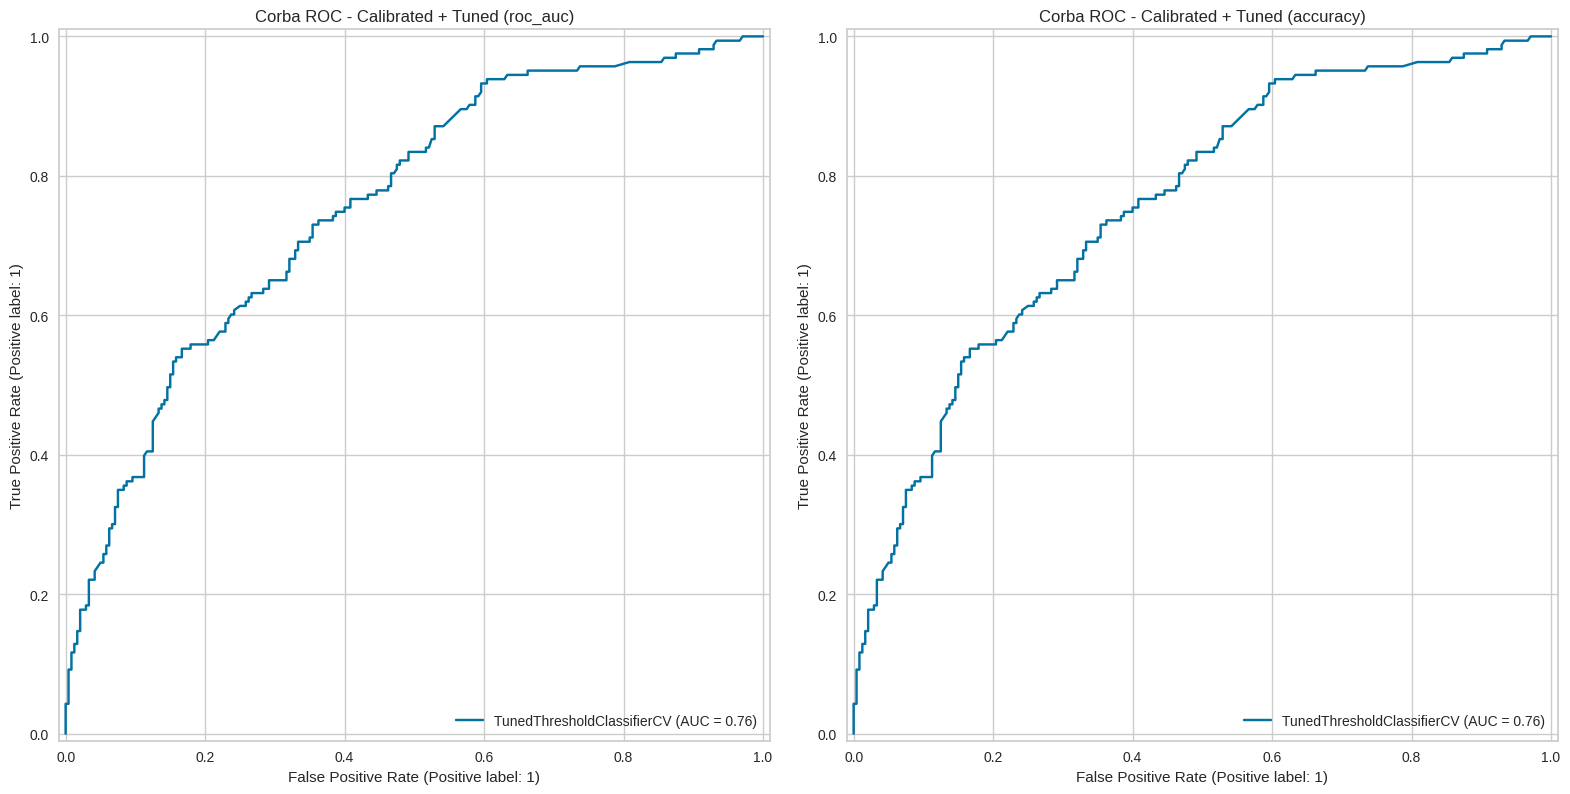

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
RocCurveDisplay.from_estimator(tuned_calibrated_roc, X_test_sd, y_test, ax=axes[0])
RocCurveDisplay.from_estimator(tuned_calibrated_acc, X_test_sd, y_test, ax=axes[1])
axes[0].set_title('Corba ROC - Calibrated + Tuned (roc_auc)')
axes[1].set_title('Corba ROC - Calibrated + Tuned (accuracy)')
plt.tight_layout()
plt.show()

Les dues corbes ROC són bastant similars, ambdues amb un **AUC** de 0.76. Però la segona (accuracy) és clarament millor per a aquest problem, ja que com hem vist ja (amb la corba ROC, confussion matrix i classifcation report) minimitza els falsos positus i és més precisa en detectat si és potable.

En altres paraules, el model que millor s'ajusta en el nostre cas és **optimitzar per accuraccy** (dels que partiem de calibrated).

### Comparar els resultats dels classificadors

In [46]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
MLP + Calibrated + Tuned Acc,0.677,0.717,0.712,0.687,0.691
MLP + Calibrated,NaN,0.715,0.710,0.683,0.687
MLP,0.683,0.687,0.675,0.675,0.675
MLP + TunedThreshold (acc),0.675,0.685,0.673,0.673,0.673
MLP + Calibrated + Tuned Roc,0.644,0.672,0.672,0.679,0.669
MLP + TunedThreshold (roc),0.643,0.655,0.669,0.673,0.655
GNB,0.616,0.625,0.611,0.564,0.542
Logistic Regression,0.599,0.596,0.548,0.501,0.379


Al llarg d'aquest problema hem entrenat un total de 8 clasificadors (ordenats per accuracy):
1. **MLP + Calibrated + Tuned (Accuracy)**
2. **MLP + Calibrated**
3. **MLP**
4. **MLP + TunedThreshold (Accuracy)**
5. **MLP + Calibrated + Tuned (roc_auc)**
6. **MLP + TunedThreshold (roc_auc)**
7. **GNB**
8. **Regressió Logística**

- Pel que fa els models lineals (GNB i Regressió Logistica):

    Hem vist que aquest models son una castaña, no prediuen bé, però és que és obvi ja que com he anat dient al llarg del treball, les variables tenen relacions no lineals, és a dir, aquests models ni els tindria en compte a l'hora de valorar quin model es millor.  
    Sobretot, hem veig obligat a recordar que la regressió logística classificava tot com aigua no potable, en altres paraules, inservible. I la seva corba ROC estava per sota que la del atzar (0.5).

    Puc agafar un model lineal per aquest problema? **NO**, s'ha vist, s'ha dit, i s'ha demostrat que hi ha relacions no lineals, i els models lineals (com és obvi) no les capturen.

- Pel que fa el MLP pur, sense ser manipulat:

    Ha estat el primer model que ens ha donat un resultat més bo que el del atzar, en altres paraules, ens ha confirmat que es tractava d'un problema no lineal. Comparant el valor **AUC** dels lineals doncs l'ha millorat significativament del 0.48 del LR fins el 0.75

- Ajustats mitjançant TunedThresholdClassifierCV (pur):

    En aquest grup tenim dos models, en funció de la optimització:  
    - **Accuracy**: Practicament igual al **MLP** no n'hi ha cap canvi a destacar/comparar
    - **roc_auc**: Aquí vveiem que directament ni millor, ni es mante, simplement empitjora els resultats, té una precisió molt baixa, molts falsos positius. En el nostre problema el descarto directament, la precissió del 55% de la classe 1, no hi ha qui la sostingui.

- Calibrats mitjançant CalibratedClassifierCV:
    
    Molt bon accuracy, redueix dràsticament els falsos positius, i té molt bona precissió de la classe 1 (aigua potable). Al calibrar amb isotonic, eliminem la sobre-confiança. A més, tots els f1-score estaven al voltant del ~71%. L'incovenient més gran es el recall pobre de la classe 1 (52%)

- Calibrats amb CalibratedClassifierCV + TunedThresholdClassifierCV:
    
    Aquí hem fet dues casuístiques d'optimització:  
    - **Accuraccy**: El millor model entrenat, però com a incoveninet tenim que la classe 1 segueix tenint un recall molt baix. És el model amb menys falsos positius.
    - **roc_auc**: Empitjora el model inicial del que ha partit **calibrated**, té una precissió de la classe 1 molt pobre, no el considaria per aquest problema. Haver optimitzat per roc_auc és contraproduent.

**Veredicte:** El millor model és el de **MLP + Calibrated + Tuned (Accuracy)**, ja que és el que ha tingut millors resoltats i encaixa millor en el nostre problema de falsos positus en predir l'aigua potable. Però si haig de donar una opinió, doncs personalment hem quedaria amb el de **MLP + Calibrated**, per què si els resultats son pitjors? A veure, pitjors no són, són una mica inferiors, varien molt pocs entre ells, però per què trio aquest? Doncs perque en temps d'execucció és significativament menor i els resultats son pràcticament idéntics. Però torno a dir, el millor model és **MLP + Calibrated + Tuned (Accuracy)**.
